In [272]:
import pandas as pd
df = pd.read_excel('C:/Users/dstoc/Documents/Python Scripts/First Project/ICE Agg.xlsx')
df2 = df.copy()

df2 = df2.iloc[0:len(df2),]

In [273]:
df2['Maturity Date'][0] - datetime.now()

Timedelta('1150 days 10:25:29.555733')

In [274]:
df2['Maturity Date'][0].strftime("%Y-%m-%d")

'2026-09-22'

In [275]:
from datetime import datetime, timedelta

# Define the date format
date_format = "%Y-%m-%dT%H:%M:%S.%f"

# Define a function to convert a date string to the number of days away
def convert_to_years(date_str):
    #date_obj = datetime.strptime(date_str, date_format)
    date_obj = date_str#.strftime("%Y-%m-%d")
    current_date = datetime.now()
    years_away = (date_obj - current_date).days / 365

    if years_away < 0:
        years_away = years_away + 100  # Add 100 years (365.25 days per year on average)
    
    return years_away

# Apply the function to the 'Date' column
df2['MaturityYears'] = df2['Maturity Date'].apply(convert_to_years)


In [276]:
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols
from matplotlib import pyplot as plt

def my_NS_func(x_df):
    time = np.array(x_df["MaturityYears"])
    yld = np.array(x_df["OAS"])


    curve, status = calibrate_ns_ols(
        time,yld, tau0= 0.10
    )  
    assert status.success
    curve  

    Yhat = x_df['OAS'].apply(curve)
    x_df.loc[:,'Yhat'] = Yhat

    Spread_to_Curve = x_df['OAS'] - x_df['Yhat']
    return Spread_to_Curve

In [284]:
df3 = df2.copy()
df3['OAS'] = df3['OAS'].astype(float)
df3 = df3.dropna(subset='OAS')
df3 = df3[df3['Industry Lvl 3 Code'] == 'Tech']
df3 = df3[df3['Rating'].isin(['BBB1','BBB2','BBB3'])]

In [278]:
df3['OAS'].isna().any()

False

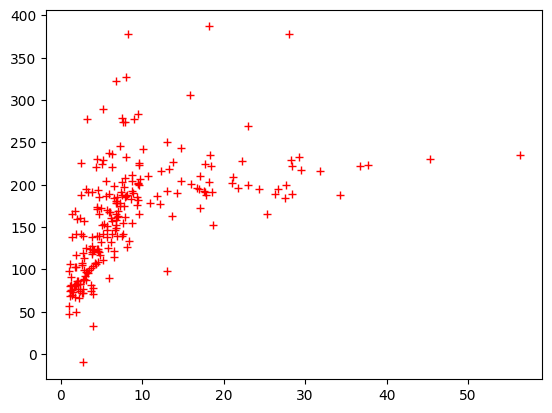

In [279]:
time = np.array(df3["MaturityYears"])
yld = np.array(df3["OAS"])
plt.plot(time,yld, "r+"); 


In [280]:
curve, status = calibrate_ns_ols(
    time,yld, tau0=0.1
)  
assert status.success
curve  

NelsonSiegelCurve(beta0=240.85585028043653, beta1=-96.27528424907354, beta2=-353.80082758731174, tau=0.9423870299589661)

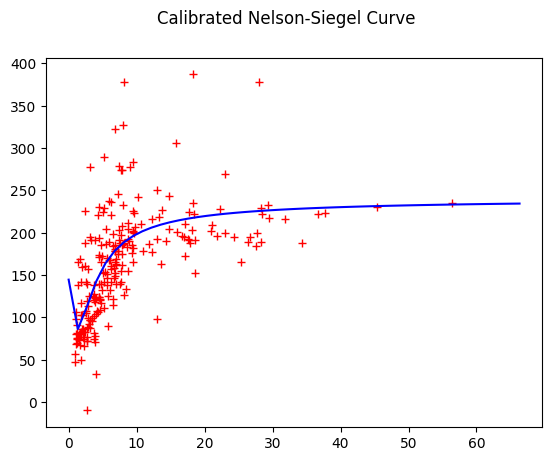

In [281]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Calibrated Nelson-Siegel Curve")
ax.plot(time, yld, "r+")
t2 = np.linspace(0, df3['MaturityYears'].max() +10 )
ax.plot(t2, curve(t2), "b-");

In [330]:
df3['Yhat'] = df3['MaturityYears'].apply(curve)
#x_df.loc[:,'Yhat'] = Yhat

df3['Spread to Curve'] = df3['OAS'] - df3['Yhat']

In [331]:
df4 = df3.copy()
df4['Issuer Avg Spread to Curve'] = df4.groupby('Ticker')['Spread to Curve'].transform('mean')

In [332]:
df4['Ticker'].nunique()

41

In [289]:
import yfinance as yf
import pandas as pd



In [290]:

def get_financial_ratios(ticker):
    # Get financial data using yfinance
    company = yf.Ticker(ticker)
    financials = company.quarterly_financials
    bal_sht = company.quarterly_balance_sheet
    inc_stmt = company.quarterly_income_stmt
    cash_flw_stmt = company.quarterly_cash_flow

    # Calculate relevant financial ratios
    debt_to_equity = bal_sht.loc["Total Debt"][0] / bal_sht.loc["Stockholders Equity"][0]
    interest_coverage = inc_stmt.loc["Operating Income"][0] / inc_stmt.loc["Interest Expense"][0]

    # Altman Z-score components
    working_capital = bal_sht.loc["Current Assets"][0] - bal_sht.loc["Current Liabilities"][0]
    retained_earnings = bal_sht.loc["Retained Earnings"][0]
    EBIT = inc_stmt.loc["Total Operating Income As Reported"][0]
    total_assets = bal_sht.loc["Total Assets"][0]
    total_equity = bal_sht.loc["Stockholders Equity"][0]
    total_liabilities = total_assets - total_equity

    z_score = 1.2 * (working_capital / total_assets) + 1.4 * (retained_earnings / total_assets) + \
               3.3 * (EBIT / total_assets) + 0.6 * (total_equity / total_assets) + 1.0 * (total_liabilities / total_assets)

    # Create a dictionary with the results
    ratios = {
        "Debt-to-Equity Ratio": debt_to_equity,
        "Interest Coverage Ratio": interest_coverage,
        "Altman Z-Score": z_score,
    }

    return ratios


In [291]:
def evaluate_companies(tickers):
    results = []
    for ticker in tickers:
        try:
            ratios = get_financial_ratios(ticker)
            results.append(pd.DataFrame([ratios], index=[ticker]))
        except Exception as e:
            print(f"Error evaluating {ticker}: {e}")

    # Merge all dataframes into a single dataframe
    merged_df = pd.concat(results)
    return merged_df


In [305]:

if __name__ == "__main__":
    # List of company tickers you want to evaluate
    #company_tickers = ["AAPL", "MSFT", "GOOGL", "META", "ORCL"]
    company_tickers = df4['Ticker'].unique()

    # Evaluate companies and get the results as a dataframe
    credit_quality_df = evaluate_companies(company_tickers)
    print(credit_quality_df)


Error evaluating DXC: 'Total Operating Income As Reported'
Error evaluating GIBACN: 'Total Debt'
Error evaluating HYUELE: 'Total Debt'
Error evaluating KD: 'Total Operating Income As Reported'
Error evaluating LENOVO: 'Total Debt'
Error evaluating LWSN: 'Total Debt'
Error evaluating MOLX: 'Total Debt'
Error evaluating NECELE: 'Total Debt'
Error evaluating NOKIA: 'Total Debt'
Error evaluating OTEXCN: 'Total Debt'
Error evaluating SUMDIG: 'Total Debt'
Error evaluating XIAOMI: 'Total Debt'
      Debt-to-Equity Ratio  Interest Coverage Ratio  Altman Z-Score
ADSK              2.992196                      NaN        0.544195
APH               0.574843                17.825714        1.707895
AVGO              1.786295                 9.918519        1.261819
BAH               3.086211                -1.172062        1.427873
DELL             -9.405227                 2.936813        0.814675
DOX               0.224167                62.041184        2.400084
FLEX              0.760081      

In [308]:
credit_quality_df.reset_index(inplace=True)
credit_quality_df = credit_quality_df.rename(columns = {'index':'Ticker'})

In [333]:
credit_quality_df2 = credit_quality_df.copy()
credit_quality_df2 = credit_quality_df2.iloc[:,0:4]

In [334]:
credit_quality_df2["Issuer Avg Spread to Curve"] = np.nan

In [335]:
for ticker in credit_quality_df2['Ticker']:
    temp_df = df4[df4['Ticker'] == ticker]
    credit_quality_df2.loc[credit_quality_df2['Ticker'] == ticker, 'Issuer Avg Spread to Curve'] = temp_df['Issuer Avg Spread to Curve'].iloc[0]

In [323]:
import pandas as pd
import dash
from dash import dcc
from dash import html


In [336]:
# Create a Dash web application
app = dash.Dash(__name__)

# Define the layout of the application
app.layout = html.Div([
    html.H1("Credit Quality Data Visualization"),
    
    # Dropdown for selecting x-axis column
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df2.columns],
        value='Debt-to-Equity Ratio'  # Default value for x-axis
    ),

    # Dropdown for selecting y-axis column
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df.columns],
        value='Altman Z-Score'  # Default value for y-axis
    ),

    # Graph component for displaying the interactive chart
    dcc.Graph(id='credit-quality-chart')
])

# Define callback to update the chart based on user selections
@app.callback(
    dash.dependencies.Output('credit-quality-chart', 'figure'),
    [dash.dependencies.Input('x-axis-dropdown', 'value'),
     dash.dependencies.Input('y-axis-dropdown', 'value')]
)
def update_chart(x_axis_column, y_axis_column):
    # Create a scatter plot with the selected columns as x and y axes
    figure = {
        'data': [{
            'x': credit_quality_df2[x_axis_column],
            'y': credit_quality_df2[y_axis_column],
            'mode': 'markers',
            'type': 'scatter',
            'text': credit_quality_df2.Ticker,
            'marker': {'size': 12}
        }],
        'layout': {
            'title': f'{y_axis_column} vs. {x_axis_column}',
            'xaxis': {'title': x_axis_column},
            'yaxis': {'title': y_axis_column}
        }
    }
    return figure


In [337]:
# Run the application
if __name__ == '__main__':
    app.run_server(debug=True)

Interpretation of Altman Z-Score:

Z-Score > 2.99: Safe Zone 
    - The company is considered safe, and the likelihood of bankruptcy is low.

1.8 < Z-Score < 2.99: Grey Zone 
    - The company is in a borderline financial situation, and caution is required.

Z-Score < 1.8: Distress Zone 
    - The company is at higher risk of bankruptcy, indicating financial distress.

OAS minus the fitted value from the Nelson-Siegel curve.
    - Positive value indicates that the bond trades wider than anticipated.
    - the average of each issuer is used to approximate average value

In [ ]:
aapl = yf.Ticker("AAPL")

# get all stock info
aapl_fin = aapl.quarterly_financials
aapl_bs = aapl.quarterly_balance_sheet
aapl_is = aapl.quarterly_income_stmt
aapl_cf = aapl.quarterly_cash_flow